In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
def create_label_words(data: pd.DataFrame, label: str) -> pd.Series:
    label_words = []
    for text in data[data["label"] == label]["text"]:
        for word in text.split():
            label_words.append(word)
    label_words = pd.Series(label_words)
    return label_words

In [3]:
def create_vocab(data: list) -> list:
    vocab = set()
    for text in data:
        for word in text.split():
            vocab.add(word)
    vocab = list(vocab)
    return vocab

In [4]:
def prepare_dataset(dataset_path: str) -> tuple:
    DATA_PATH = dataset_path
    data = pd.read_csv(DATA_PATH)
    data = data.rename(columns={"text": "text", "category": "label"})    
    vocab =  create_vocab(data["text"])
    labels = data["label"].unique()
    
    first_label = labels[0]
    second_label = labels[1]

    first_label_words = create_label_words(data, first_label)
    second_label_words = create_label_words(data, second_label)

    first_label_words = first_label_words.value_counts()
    second_label_words = second_label_words.value_counts()

    return vocab, first_label_words, second_label_words

In [5]:
def create_individual(word_count: int, vocab: list) -> list:
    individual = [[], []]
    for i in range(word_count // 2):
        individual[0].append(random.choice(vocab))
        individual[1].append(random.choice(vocab))
    return individual

In [6]:
def create_population(population_size: int, word_count: int, vocab: list) -> list:
    population = []
    for i in range(population_size):
        individual = create_individual(word_count, vocab)
        if individual not in population:
            population.append(individual)
    return population

In [7]:
def find_fitness(
    individual: list, first_label_words: pd.Series, second_label_words: pd.Series
) -> int:
    fitness = 0
    for word in individual[0]:
        if word in first_label_words:
            fitness += first_label_words[word]
        if word in second_label_words:
            fitness -= second_label_words[word]
    for word in individual[1]:
        if word in second_label_words:
            fitness += second_label_words[word]
        if word in first_label_words:
            fitness -= first_label_words[word]
    return fitness

In [8]:
def find_population_fitness(
    population: list, first_label_words: pd.Series, second_label_words: pd.Series
) -> list:
    population_fitness = []
    for individual in population:
        population_fitness.append(
            find_fitness(individual, first_label_words, second_label_words)
        )
    return population_fitness

In [9]:
def find_best(population: list, population_fitness: list) -> list:
    best_index = population_fitness.index(max(population_fitness))
    return population[best_index]

In [10]:
def find_elites(population: list, population_fitness: list, elite_size: int) -> list:
    elites = []
    for i in range(elite_size):
        best_index = population_fitness.index(max(population_fitness))
        elites.append(population[best_index])
        population_fitness[best_index]
    return elites

In [11]:
def crossover(parent1: list, parent2: list) -> list:
    child = [[], []]
    for i in range(len(parent1[0])):
        if random.random() > 0.5:
            child[0].append(parent1[0][i])
            child[1].append(parent2[1][i])
        else:
            child[0].append(parent2[0][i])
            child[1].append(parent1[1][i])
    return child

In [12]:
def mutate(individual: list, mutation_rate: float, vocab: list) -> list:
    for i in range(len(individual[0])):
        if random.random() < mutation_rate:
            individual[0][i] = random.choice(vocab)
        if random.random() < mutation_rate:
            individual[1][i] = random.choice(vocab)
    return individual

In [13]:
def check_if_unique(individual: list) -> bool:
    if len(set(individual[0])) != len(individual[0]):
        return False
    if len(set(individual[1])) != len(individual[1]):
        return False
    return True


def evolve(
    population: list,
    population_fitness: list,
    elite_size: int,
    mutation_rate: float,
    vocab: list,
) -> list:
    elites = find_elites(population, population_fitness, elite_size)
    next_generation = elites
    while len(next_generation) < len(population):
        parent1 = random.choice(next_generation)
        parent2 = random.choice(next_generation)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate, vocab)
        if child not in next_generation and check_if_unique(child):
            next_generation.append(child)
    return next_generation

In [14]:
def genetic_algorithm(
    population_size: int,
    elite_size: int,
    mutation_rate: float,
    generation_count: int,
    word_count: int,
    vocab: list,
    first_label_words: pd.Series,
    second_label_words: pd.Series,
) -> tuple:
    population = create_population(population_size, word_count, vocab)
    plot_data = {}
    for i in range(generation_count):
        population_fitness = find_population_fitness(
            population, first_label_words, second_label_words
        )
        population = evolve(
            population, population_fitness, elite_size, mutation_rate, vocab
        )
        plot_data[i] = {
            "max": max(population_fitness),
            "avg": sum(population_fitness) / len(population_fitness),
        }
    population_fitness = find_population_fitness(
        population, first_label_words, second_label_words
    )
    best = find_best(population, population_fitness)
    return best, population_fitness, plot_data

In [15]:
def plot_generations_fitness_graph(plot_data: dict, title: str, description: str = None):
    plt.figure(figsize=(5, 5))
    plt.plot(
        list(plot_data.keys()),
        [plot_data[key]["max"] for key in plot_data.keys()],
        label="Max",
    )
    plt.plot(
        list(plot_data.keys()),
        [plot_data[key]["avg"] for key in plot_data.keys()],
        label="Avg",
    )
    plt.legend()
    plt.title(title)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    if description:
        plt.text(25, 50, description)
    return plt

In [16]:
data_path = "/kaggle/input/data-preprocessing/train_processed.csv"
PARAMETER_LIST = [
    # word_count changes
    [
        {
            "population_size": 1000,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 1000,
            "word_count": 110,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 500,
            "word_count": 120,
            "mutation_rate": 0.01,
        },
    ],
    # population_size changes
    [
        {
            "population_size": 1000,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 1100,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 1200,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
    ],
    # mutation_rate changes
    [
        {
            "population_size": 1000,
            "word_count": 100,
            "mutation_rate": 0.01,
        },
        {
            "population_size": 1000,
            "word_count": 100,
            "mutation_rate": 0.05,
        },
        {
            "population_size": 1000,
            "word_count": 100,
            "mutation_rate": 0.10,
        },
    ],
]

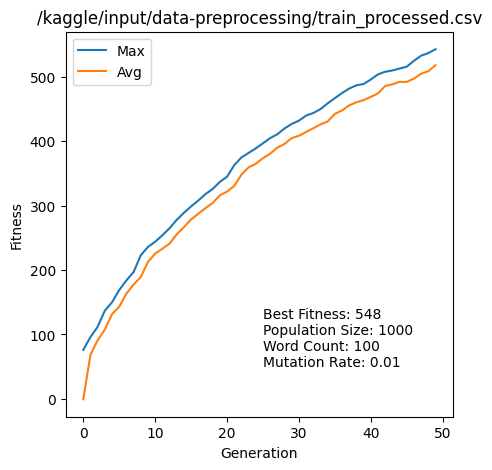

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1000, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['beat', 'chris', 'gold', 'major', 'interim', 'sunday', 'jersey', 'inning', 'fleeting', 'strait', 'acting', 'africa', 'michael', 'left', 'bryants', 'singh', 'iran', 'indian', 'olympic', 'whistling', 'volleyball', 'league', 'championship', 'saturday', 'phelps', 'everythings', 'quest', 'czech', 'edge', 'medal', 'haas', 'poised', 'good', 'york', 'chicago', 'party', 'athens', 'hungarian', 'honor', 'took', 'eight', 'freestyle', 'consecutive', 'team', 'reuters', 'game', 'tennis', 'mcgahee', 'race', 'injury'], ['logger', 'deepsea', 'tuesday', 'mobile', 'increased', 'sale', 'prize', 'increasingly', 'nasa', 'conspiracy', 'department', 'spacecom', 'leaf', 'saudi', 'parent', 'expedition', 'probably', 'misery', 'university', 'technology', 'scientist', 'said', 'telescope', 'afraid', 'wanted', 'many', 'privacy', 'thursday', 'apple', 'study

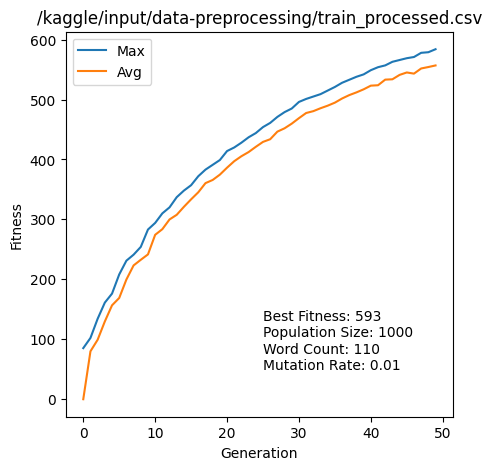

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1000, 'word_count': 110, 'mutation_rate': 0.01}
Best individual: [['championship', 'team', 'rivalry', 'come', 'left', 'victory', 'minnesota', 'crew', 'cleveland', 'everton', 'race', 'best', 'stahl', 'castillo', 'stay', 'freestyle', 'saturday', 'leonard', 'olympic', 'athens', 'tour', 'exteam', 'greek', 'final', 'sunday', 'york', 'hungarian', 'indian', 'overlooking', 'phelps', 'williams', 'first', 'strength', 'field', 'medal', 'exactly', 'gold', 'beat', 'clear', 'loss', 'fernando', 'quest', 'john', 'tworun', 'inning', 'title', 'compete', 'game', 'singh', 'qualifying', 'equaling', 'night', 'back', 'michael', 'wrap'], ['well', 'max_connections', 'reported', 'mozilla', 'braincompound', 'japan', 'would', 'prize', 'million', 'meteor', 'mexception', 'said', 'claim', 'gammaray', 'vietnam', 'visual', 'scientist', 'trading', 'surrender', 'system', 'unidentified', 'dolphin', 'space', 'manually', 'perce

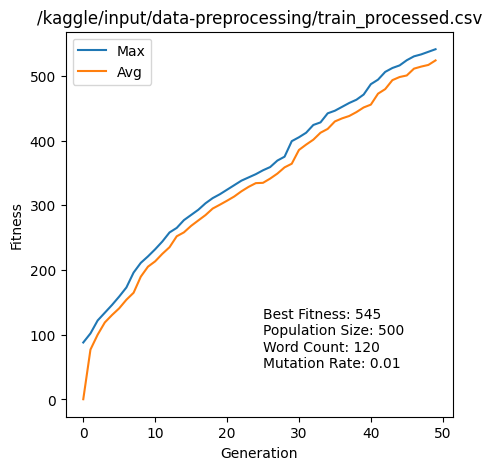

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 500, 'word_count': 120, 'mutation_rate': 0.01}
Best individual: [['track', 'vijay', 'itsbulk', 'israeli', 'latasha', 'mcgahee', 'club', 'season', 'left', 'jones', 'first', 'chicago', 'ninth', 'race', 'saturday', 'made', 'scott', 'saudiarabia', 'hungarian', 'olympic', 'tournament', 'sunday', 'schumacher', 'phelps', 'everythings', 'overlooking', 'didnt', 'last', 'twin', 'begin', 'pimlico', 'athens', 'yesterday', 'daniela', 'puerto', 'performance', 'gotten', 'suspended', 'elevator', 'cutter', 'keller', 'gold', 'even', 'normal', 'michael', 'medal', 'dimarco', 'state', 'everyone', 'vice', 'team', 'united', 'hartman', 'bryants', 'andy', 'york', 'furlong', 'yard', 'knocked', 'final'], ['would', 'customer', 'chief', 'customize', 'logger', 'agency', 'pena', 'exception', 'spacecom', 'advisory', 'shower', 'lunch', 'people', 'telescope', 'fish', 'comet', 'time', 'property', 'swarm', 'businessman', 'dis

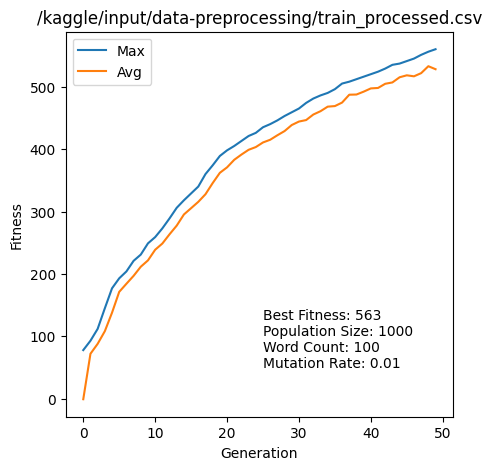

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1000, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['schumacher', 'disaster', 'freestyle', 'hold', 'wrap', 'phelps', 'loss', 'minnesota', 'wood', 'eight', 'injury', 'budapest', 'singh', 'race', 'driver', 'michael', 'walsh', 'championship', 'inning', 'burn', 'saturday', 'game', 'amateur', 'beat', 'gold', 'yesterday', 'athens', 'clash', 'potentially', 'title', 'united', 'victory', 'team', 'made', 'mariner', 'putter', 'season', 'sunday', 'medal', 'tough', 'inside', 'nationwide', 'reconsider', 'knee', 'greek', 'form', 'olympic', 'australia', 'offense', 'reaping'], ['claim', 'alone', 'rise', 'mozilla', 'logger', 'month', 'standard', 'going', 'static', 'growth', 'website', 'science', 'customer', 'many', 'deepest', 'runtime', 'rose', 'daemon', 'scientist', 'reach', 'max_connections', 'expert', 'spacecom', 'blog', 'space', 'format', 'wednesdaythey', 'cool', 'display', 'rocket', 'side

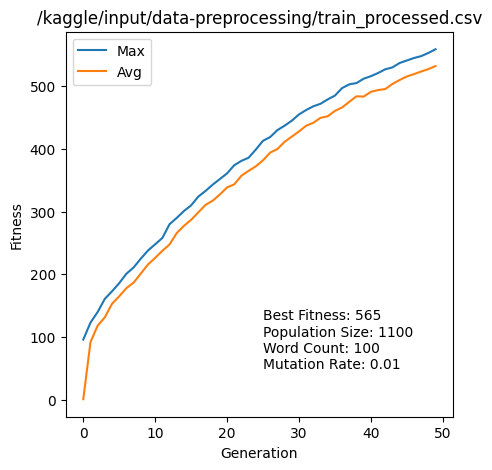

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1100, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['game', 'andy', 'loss', 'winning', 'summer', 'another', 'michael', 'final', 'olympic', 'dream', 'left', 'sunday', 'athens', 'johnson', 'qualifying', 'rookie', 'indian', 'phelps', 'wood', 'dimarco', 'first', 'leonard', 'redskin', 'ninth', 'gold', 'title', 'australia', 'beat', 'medal', 'saturday', 'suspended', 'freestyle', 'season', 'match', 'york', 'inning', 'early', 'singh', 'stayed', 'olympics', 'wrap', 'itthis', 'cruised', 'championship', 'lynx', 'playoff', 'beating', 'team', 'eight', 'knocked'], ['siberia', 'measure', 'going', 'causing', 'growth', 'powerful', 'property', 'scientist', 'attack', 'spacecom', 'planning', 'cargo', 'sunlight', 'churchno', 'nasa', 'allawi', 'junk', 'would', 'rhino', 'trying', 'mesmerizing', 'cheap', 'beach', 'delay', 'space', 'logger', 'group', 'technology', 'corp', 'disc', 'madepublic', 'statem

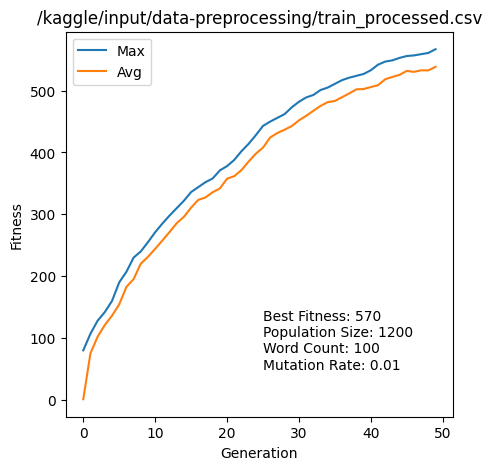

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1200, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['lead', 'strait', 'gold', 'phelps', 'left', 'homer', 'brewer', 'final', 'team', 'grand', 'champion', 'eight', 'race', 'game', 'lynx', 'season', 'budapest', 'singh', 'athens', 'healthy', 'homered', 'australia', 'birdie', 'fresh', 'loss', 'night', 'prokom', 'kneeknocking', 'earned', 'fernando', 'championship', 'lower', 'made', 'schumacher', 'twin', 'first', 'title', 'ryder', 'olympic', 'daniela', 'inning', 'sunday', 'michael', 'visiting', 'track', 'medal', 'exhibition', 'play', 'player', 'africa'], ['overwhelm', 'thursday', 'space', 'website', 'expedition', 'name', 'ponders', 'many', 'saudi', 'surrender', 'instrument', 'phenomenon', 'rain', 'rocket', 'rainfall', 'discount', 'official', 'said', 'work', 'retail', 'logger', 'hubble', 'time', 'drop', 'environmental', 'however', 'scientist', 'technology', 'europe', 'expand', 'assoc

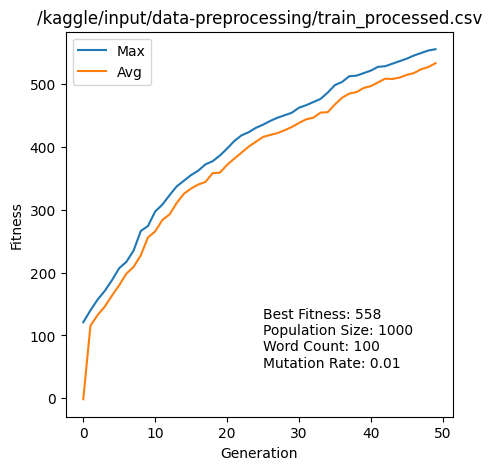

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1000, 'word_count': 100, 'mutation_rate': 0.01}
Best individual: [['wrist', 'gymnast', 'beat', 'need', 'fourhitter', 'olympics', 'mets', 'athens', 'practice', 'title', 'preseason', 'make', 'night', 'prepared', 'inning', 'misty', 'bryants', 'eight', 'singh', 'basketball', 'baltimore', 'evening', 'wrap', 'homer', 'quotwho', 'season', 'track', 'shunning', 'earned', 'freestyle', 'game', 'label', 'surgery', 'united', 'schumacher', 'clash', 'single', 'final', 'reserve', 'michael', 'round', 'olympic', 'victory', 'team', 'first', 'sunday', 'walter', 'phelps', 'championship', 'gold'], ['exaggerated', 'display', 'thursday', 'shower', 'planning', 'probe', 'expedition', 'never', 'expert', 'development', 'deeper', 'wireless', 'spacecom', 'rank', 'attack', 'people', 'said', 'hour', 'plan', 'rhino', 'turn', 'june', 'instrument', 'explode', 'dont', 'shuttle', 'pacific', 'code', 'website', 'charleys', 'japa

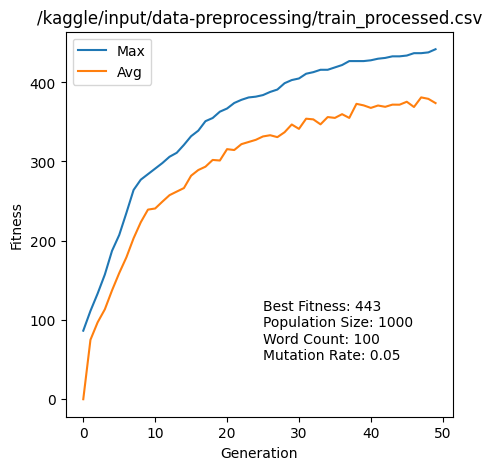

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1000, 'word_count': 100, 'mutation_rate': 0.05}
Best individual: [['tmobile', 'optimism', 'inning', 'michael', 'justin', 'eight', 'sunday', 'jones', 'team', 'katerina', 'left', 'saturday', 'final', 'clinic', 'olympic', 'substitute', 'rookie', 'back', 'defied', 'stay', 'prepared', 'rolled', 'tenth', 'grand', 'phelps', 'first', 'myskina', 'without', 'mounting', 'mcgahee', 'ankle', 'moment', 'israel', 'riley', 'court', 'street', 'gold', 'game', 'nadal', 'athens', 'knee', 'vote', 'prokom', 'york', 'strait', 'fourthquarter', 'injury', 'niceandeasy', 'empty', 'major'], ['china', 'noticing', 'visual', 'said', 'softwareproducts', 'website', 'bringing', 'hardware', 'work', 'code', 'canadian', 'chris', 'unusual', 'endangered', 'despite', 'science', 'later', 'replace', 'administration', 'encryptioncracking', 'space', 'misery', 'spacecom', 'nothing', 'would', 'check', 'unhandled', 'system', 'bush', 'vi

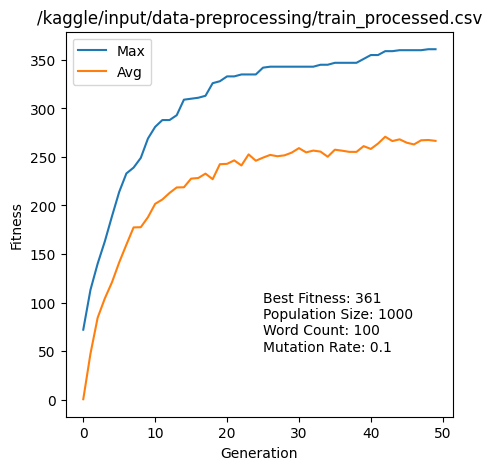

--- /kaggle/input/data-preprocessing/train_processed.csv Results ---
Params: {'population_size': 1000, 'word_count': 100, 'mutation_rate': 0.1}
Best individual: [['play', 'city', 'championship', 'wife', 'defensive', 'fresh', 'medal', 'maintains', 'didnt', 'running', 'renault', 'hungary', 'team', 'putting', 'final', 'channel', 'onemonth', 'andsoul', 'sunday', 'indian', 'sensation', 'dimarco', 'meter', 'outlasts', 'countless', 'rich', 'june', 'involve', 'landing', 'classic', 'chinese', 'lunar', 'record', 'beatup', 'first', 'know', 'relay', 'suggests', 'tech', 'friendship', 'french', 'olympic', 'player', 'athens', 'holdon', 'ymca', 'dream', 'ofshaban', 'wood', 'drizzle'], ['compassionso', 'europe', 'liberal', 'would', 'claim', 'oregon', 'instrument', 'trading', 'ampm', 'satellite', 'sample', 'never', 'freeing', 'miresmaeili', 'rocket', 'quotoptout', 'niceandeasy', 'exposure', 'send', 'name', 'spot', 'sean', 'extension', 'agency', 'code', 'thursday', 'administration', 'latest', 'dolphin', 

In [17]:
best_individuals_list = []
for parameters in PARAMETER_LIST:
    for parameter in parameters:
        best_individuals_for_params = [] 
        vocab, first_label_words, second_label_words = prepare_dataset(
            data_path
        )
        best, population_fitness, plot_data = genetic_algorithm(
            population_size=parameter["population_size"],
            elite_size=50,
            mutation_rate=parameter["mutation_rate"],
            generation_count=50,
            word_count=parameter["word_count"],
            vocab=vocab,
            first_label_words=first_label_words,
            second_label_words=second_label_words,
        )
        best_individuals_for_params.append(best)
        plot_image = plot_generations_fitness_graph(
            plot_data,
            data_path,
            f"Best Fitness: {max(population_fitness)}\nPopulation Size: {parameter['population_size']}\nWord Count: {parameter['word_count']}\nMutation Rate: {parameter['mutation_rate']}",
        )
        plot_image.show()
        print(f"--- {data_path} Results ---")
        print("Params:", parameter)
        print("Best individual:", best)
        print("Best fitness:", max(population_fitness))
        best_individuals_list.append(best_individuals_for_params)


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

evaluation_results = []
i=0
train_df=pd.read_csv("/kaggle/input/data-preprocessing/train_processed.csv")
test_df=pd.read_csv("/kaggle/input/data-preprocessing/test_processed.csv")
X_train=train_df["text"]
X_test=test_df["text"]
y_train=train_df["category"]
y_test=test_df["category"]
best_individual = best_individuals_list[i][0][0] + best_individuals_list[i][0][1]
best_individual = list(set(best_individual))

vectorizer = TfidfVectorizer(vocabulary=best_individual)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
    
    # Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
    
predictions = naive_bayes_model.predict(X_test)
report = classification_report(y_test, predictions, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
    
evaluation_results.append({
        'Model': 'Multinomial Naive Bayes',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

    # Gaussian Naive Bayes
gaussian_nb_model = GaussianNB()
gaussian_nb_model.fit(X_train.toarray(), y_train)
    
predictions = gaussian_nb_model.predict(X_test.toarray())
report = classification_report(y_test, predictions, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
    
evaluation_results.append({
        'Model': 'Gaussian Naive Bayes',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

    # SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
    
predictions = svm_model.predict(X_test)
report = classification_report(y_test, predictions, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
    
evaluation_results.append({
        'Model': 'SVM',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    })

evaluation_results_df = pd.DataFrame(evaluation_results)
evaluation_results_df


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/pyt

,Model,Accuracy,Precision,Recall,F1-Score
0,Multinomial Naive Bayes,0.90,0.917391,0.90,0.899499
1,Gaussian Naive Bayes,0.85,0.852813,0.85,0.849242
2,SVM,0.90,0.917391,0.90,0.899499
